In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda:4'
print(torch.__version__)
from dennytools.silence import *

1.2.0


In [2]:
BS = 10

train = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=BS, shuffle=True, pin_memory=False)

# Test dataset
test = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=BS, shuffle=True, pin_memory=False)

In [3]:
def display(imgs, shape=(28,28)):
    
    if (len(imgs) == 1):
        rows = math.ceil(imgs[0].shape[0]/5)
        cols = 5
        fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(2*cols, 2*rows))
        for i in range(imgs[0].shape[0]):
            px = i//cols
            py = i%cols
            ax[px,py].imshow(imgs[0][i].view(shape).detach().cpu(), cmap='gray', vmin=0, vmax=1)
        plt.show()        
    else:
        rows = imgs[0].shape[0]
        cols = len(imgs)
        fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(2*cols, 2*rows))
        for c, img in enumerate(imgs):
            py = c
            for i in range(img.shape[0]):
                px = i 
                ax[px,py].imshow(img[i].view(shape).detach().cpu(), cmap='gray', vmin=0, vmax=1)
        plt.show()

In [4]:
def entropy(means):
    zeromask = (means == 0).float()
    onesmask = (means == 1).float()
    safemean = 1e-8*zeromask - 1e-8*onesmask + means
    
    return - safemean*torch.log2(safemean) - (1-safemean)*torch.log2(1-safemean)

def tent(means):
    less = (means < 0.5).float()
    more = (means >= 0.5).float()
    return (means*less + (1-means)*more)*2

def one(means):
    return torch.ones_like(means)

class AWSDM(nn.Module):
    def __init__(self, addressDim, messageDim=None, locations=10000, gamma=0.05,
                 init_radius=1, target_p=0.1, r_lr=1, counter_range=None,
                 dtype=torch.float, readtype=torch.float, weightFunc=entropy):
        super().__init__()
        if (messageDim is None):
            messageDim = addressDim
        
        self.addressDim = addressDim
        self.messageDim = messageDim
        self.N = locations
        self.radius = init_radius
        self.target_p = target_p
        self.r_lr = r_lr
        self.counter_range = counter_range
        self.dtype = dtype
        self.readtype = readtype
        
        self.weightFunc = weightFunc 
        
        self.gamma = gamma
        
        self.register_buffer('locations', torch.randint(0,2, (1, locations, addressDim), dtype=torch.float))
        self.register_buffer('counter', torch.zeros((1, locations, messageDim), dtype=dtype))
        self.register_buffer('means', 0.5*torch.ones(1, 1, addressDim, dtype=torch.float))
        
    def _checkInput(self, input, dim, name):
        # Input shape checking (and fixing) function
        if (len(input.shape) == 1):
            input = input.unsqueeze(0).unsqueeze(0)
        elif (len(input.shape) == 2):
            input = input.unsqueeze(1)
        elif (len(input.shape) == 3):
            pass
        else:
            raise ValueError("{} has bad shape, got {}".format(name, input.shape))
            
        if (input.shape[2] != dim):
            raise ValueError("{} has wrong dimension, got {} expected {}".format(name, input.shape[1], dim))
        
        return input
    
    def _getWeights(self):
        return self.weightFunc(self.means)
    
    def _getActive(self, address):
        with torch.no_grad():
            address = address.float()#.char()
            address = self._checkInput(address, self.addressDim, "Address")
            # Calculate Hamming distance
            hamming = ((self.locations + address).fmod_(2))#.float()
            hamming *= self._getWeights()
            hamming = hamming.sum(-1, keepdim=True)
            # Return array
            return (hamming <= self.radius).float()#.char()
        
    def _updateMeans(self, address):
        address = self._checkInput(address, self.addressDim, "Address")
        mean = address.float().mean(0, keepdim=True,)
        self.means += self.gamma*(mean-self.means)
    
    def write(self, address, message):
        with torch.no_grad():
            message = message.float()#.char()
            message = self._checkInput(message, self.messageDim, "Message")
            message = 2 * message - 1
            
            self._updateMeans(address)
            active = self._getActive(address)
            self.counter += (active*message.expand(-1, self.N, -1)).sum(0, keepdim=True, dtype=self.dtype)
            # Clamp counter if range given
            if (self.counter_range is not None):
                self.counter.clamp_(-self.counter_range, self.counter_range)
            
            # Update radius
            diff = self.target_p - active.mean().item()
            self.radius += diff*self.r_lr*address.shape[0]
            
    def read(self, address):
        with torch.no_grad():
            active = self._getActive(address).to(self.dtype)
            result = (active*self.counter).sum(1, dtype=self.dtype)
            return (result > 0).to(self.readtype)
        
    def clear(self):
        self.counter.zero_()

In [33]:
Adim = 784
Mdim = 784
Nloc = 100000

WriteBatches = 500

mem = AWSDM(Adim, Mdim, Nloc, weightFunc=tent, r_lr=2, gamma=0.1,
            target_p=0.1, counter_range=40).to(device)
# mem.radius = 200

savelist = [0,5,10,20,30,40,55,100,200,500]

batches = 0
rs = [mem.radius]
maxs = [mem._getWeights().sum()]
imgs = []
initdata = None
# Write all the data in
for (data, label) in train:
    silent = not (batches < 10 or (batches < 100 and batches%10 == 0) or batches%100==0)
    with silence(silent):
        print (batches)

        data = (data.view(-1, 784) > 0).float().to(device)
        if (initdata is None):
            initdata = data
            imgs.append(initdata)

        mem.write(data, data)
        if (batches in savelist):
            imgs.append(mem.read(initdata))

        rs.append(mem.radius)
        maxs.append(mem._getWeights().sum())

        batches += 1
        if (batches == WriteBatches):
            break

# Read out one batch
# (data, label) = next(iter(train))

dprime = mem.read(initdata)

print ((dprime == initdata).sum().item()/data.storage().size())

0
1
2
3
4
5
6
7
8
9
10
20
30
40
50
60
70
80
90
100
200
300
400
0.8701530612244898


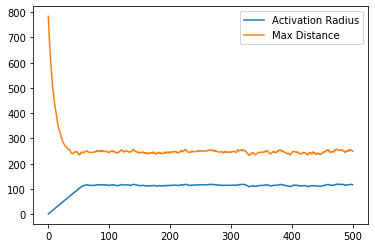

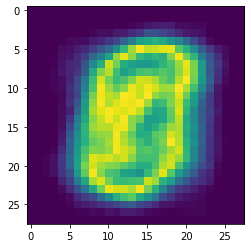

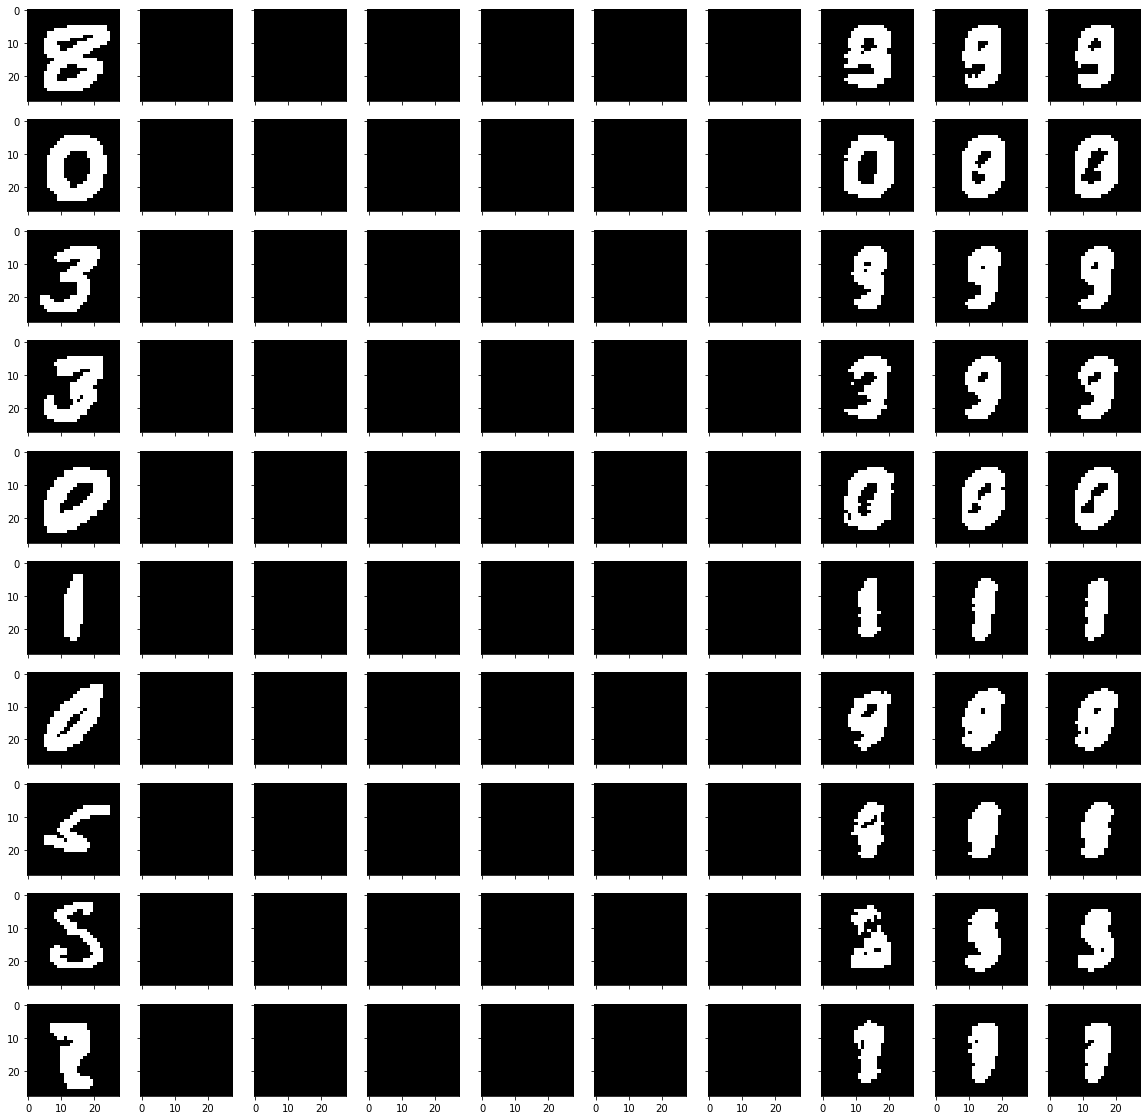

In [34]:
plt.plot(rs, label='Activation Radius')
# plt.show()
plt.plot(maxs, label='Max Distance')
plt.legend()
plt.show()

plt.imshow(mem._getWeights().view(28,28).cpu())
plt.show()

display(imgs, (28,28))

In [38]:
print (mem.counter.min(), mem.counter.max())
mem.clear()
print (mem.counter.min(), mem.counter.max())

tensor(-40., device='cuda:4') tensor(40., device='cuda:4')
tensor(0., device='cuda:4') tensor(0., device='cuda:4')


0
1
2
3
4
5
6
7
8
9
0.9228316326530612


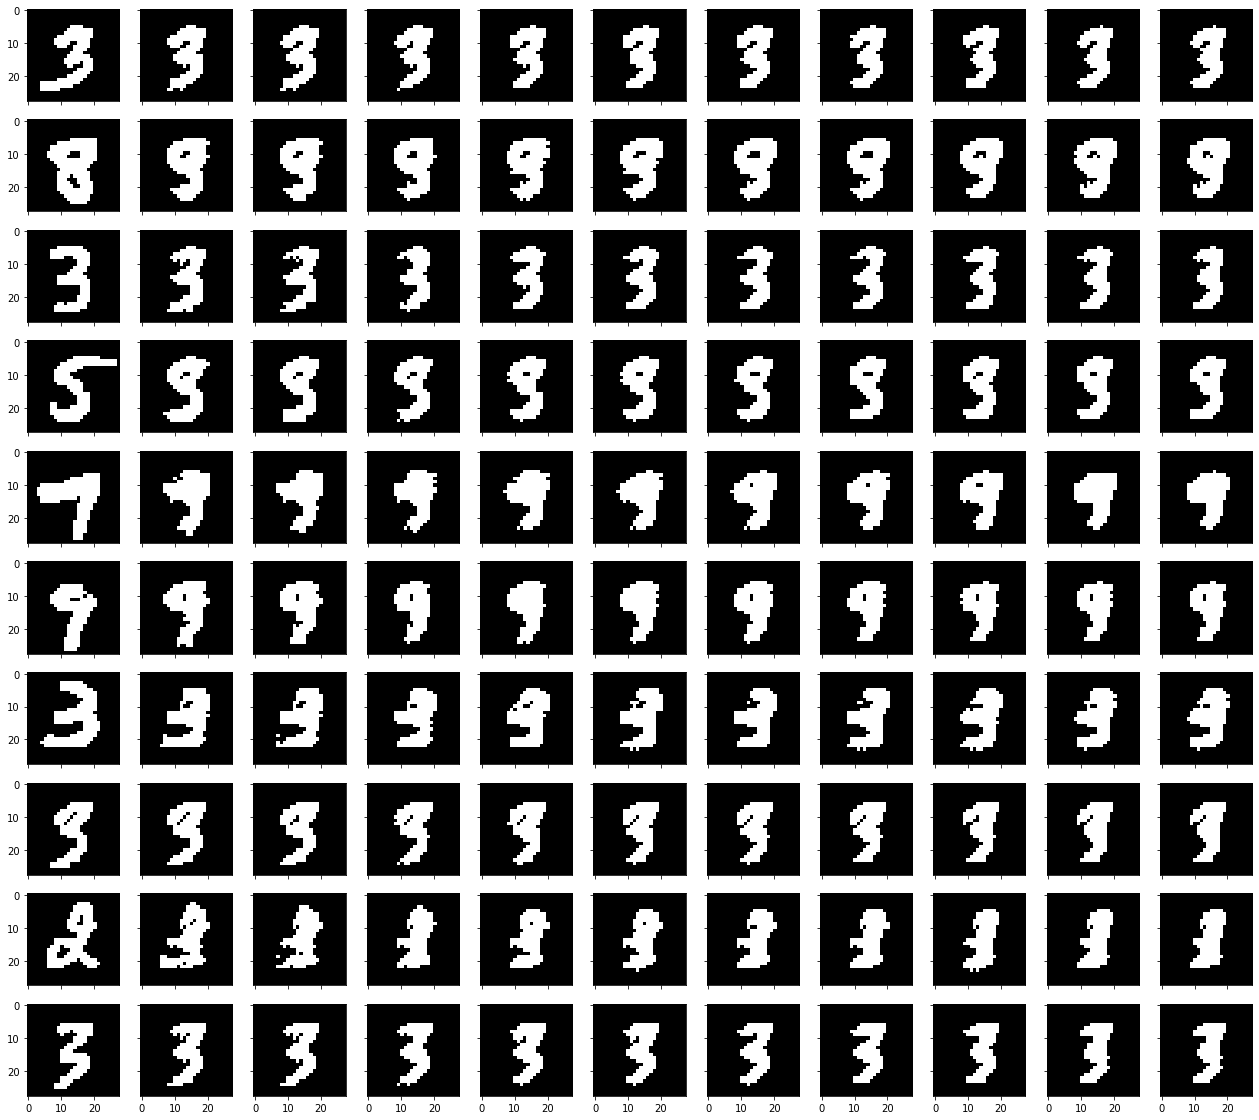

In [39]:

WriteBatches = 10
savelist = [0,5,10,20,30,40,55,100,200,500]
savelist = list(range(10))

batches = 0
rs = [mem.radius]
maxs = [mem._getWeights().sum()]
imgs = []
initdata = None
# Write all the data in
for (data, label) in train:
    silent = not (batches < 10 or (batches < 100 and batches%10 == 0) or batches%100==0)
    with silence(silent):
        print (batches)

        data = (data.view(-1, 784) > 0).float().to(device)
        if (initdata is None):
            initdata = data
            imgs.append(initdata)

        mem.write(data, data)
        if (batches in savelist):
            imgs.append(mem.read(initdata))

        rs.append(mem.radius)
        maxs.append(mem._getWeights().sum())

        batches += 1
        if (batches == WriteBatches):
            break

# Read out one batch
# (data, label) = next(iter(train))

dprime = mem.read(initdata)

print ((dprime == initdata).sum().item()/data.storage().size())
display(imgs, (28,28))